In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom_test
import os
import matplotlib.pyplot as plt
import pystan

In [2]:
data_folder = '../data/2020-06-16_clockrun_4ms/data/'
f_names = os.listdir(data_folder)
data = {}
for name in f_names:
    if ('comb' in name) or ('driftcomp' in name):
        col_names = ['MJD', 'value']
    else:
        col_names = ['MJD', 'servo_idx', 'value']
    key = name.partition('.')[0]
    data[key] = pd.read_csv(data_folder + name, sep=' ', header=None, names=col_names)

In [3]:
sm = pystan.StanModel(file="../models/test_binom.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5884ac020a5dd5f0ec929150136c231a NOW.


In [39]:
df = data['counts_blu_C4minus']
tau = df[df['MJD'] >= 59015.85].index[0]
y1, y2 = np.split(np.array(df['value']).astype(int), [tau])
binom_dat = {'N_1': tau,
             'N_2': len(df.index) - tau,
             'N_s': 100,
             'y1': y1,
             'y2': y2}
fit = sm.sampling(data=binom_dat, iter=1000, chains=4)
fit

Inference for Stan model: anon_model_baa4243747fc19420381784f6fca2815.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p1     0.17  6.4e-5 2.4e-3   0.16   0.16   0.17   0.17   0.17   1347    1.0
p2     0.15  6.1e-5 2.3e-3   0.14   0.15   0.15   0.15   0.15   1374    1.0
lp__ -2.1e4    0.03   0.99 -2.1e4 -2.1e4 -2.1e4 -2.1e4 -2.1e4    851   1.01

Samples were drawn using NUTS at Thu Jun 18 10:16:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

(array([ 11.,  30.,  84., 245., 438., 523., 373., 186.,  79.,  31.]),
 array([0.13985364, 0.14126767, 0.1426817 , 0.14409573, 0.14550976,
        0.14692379, 0.14833782, 0.14975185, 0.15116588, 0.15257991,
        0.15399393]),
 <a list of 10 Patch objects>)

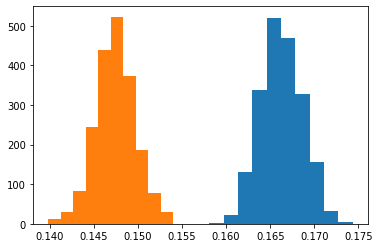

In [49]:
plt.hist(fit.extract()['p1'])
plt.hist(fit.extract()['p2'])

In [4]:
count_dfs = {k:v for k, v in data.items() if 'counts' in k}
fits = {}
for key, df in count_dfs.items():
    tau = df[df['MJD'] >= 59015.85].index[0]
    y1, y2 = np.split(np.array(df['value']).astype(int), [tau])
    binom_dat = {'N_1': tau,
                 'N_2': len(df.index) - tau,
                 'N_s': 100,
                 'y1': y1,
                 'y2': y2}
    fit = sm.sampling(data=binom_dat, iter=1000, chains=4)
    fits[key] = fit

In [8]:
sorted_keys = sorted(fits.keys(), key=lambda x: x.split('_')[-1])

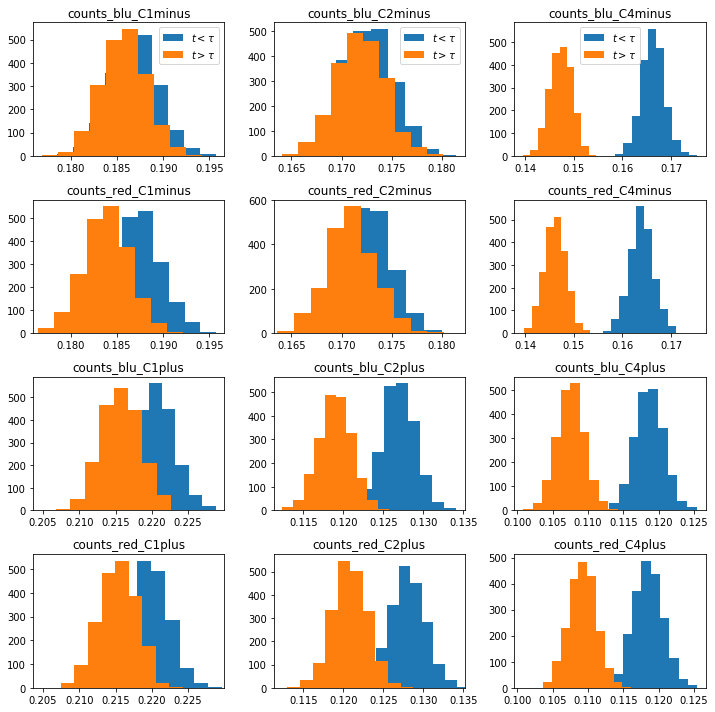

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(10, 10))
for j in range(axs.shape[1]):
    col_xlims = ()
    for i in range(axs.shape[0]):
        idx = i + axs.shape[0]*j
        title = sorted_keys[idx]
        fit = fits[title]
        axs[i][j].hist(fit.extract()['p1'], label=r'$t<\tau$')
        axs[i][j].hist(fit.extract()['p2'], label=r'$t>\tau$')
        axs[i][j].set_title(title)
        if i == 0:
            axs[i][j].legend()
        if i == 2 or i == 0:
            col_xlims = axs[i][j].get_xlim()
        axs[i][j].set_xlim(col_xlims)
plt.tight_layout()